# Load the data

In [1]:
import os
import pandas as pd

In [2]:
frameworks = ["data-driven", "rdoc"]

## Load domain scores for notes

In [3]:
scores = {}
for framework in frameworks:
    scores[framework] = {}
    file = "data/scores_similarity_{}.csv".format(framework)
    df = pd.read_csv(file, index_col=0)
    df = df[(df.T != 0).any()]
    scores[framework] = df
scores["data-driven"].head()

,MEMORY,REWARD,REACTION_TIME,MANIPULATION,VISION,HEARING
1,0.485779,0.715081,0.390165,0.015108,0.788354,0.898241
2,0.015047,0.126678,0.027840,0.550325,0.977041,0.599038
3,0.241961,0.067346,0.917730,0.857286,0.211430,0.214343
4,0.957311,0.022990,0.127114,0.017408,0.240917,0.984594
5,0.559534,0.167589,0.386947,0.563014,0.427929,0.190799


In [4]:
print("{} visits with scores for {} domains".format(*scores["data-driven"].shape))

100 visits with scores for 6 domains


## Load clinical endpoints

In [5]:
endpoints = pd.read_csv("data/endpoints.csv", index_col=0)
endpoints.head()

,ssri_exposures,snri_exposures,benzo_exposures,fga_exposures,sga_exposures,er_admissions,cost
visit_occurrence_id,,,,,,,
1,8,16,0,0,0,55,3401
2,4,53,42,12,52,0,338
3,5,0,0,0,81,0,3425
4,5,98,0,52,7,71,1172
5,0,73,6,97,71,50,2465


In [6]:
print("{} visits with {} endpoints".format(*endpoints.shape))

100 visits with 7 endpoints


## Re-index with visit occurrence IDs

In [7]:
ids = scores["data-driven"].index.intersection(endpoints.index)
for framework in frameworks:
    ids = ids.intersection(scores[framework].index)
ids = sorted(list(set(ids)))
print("{} visits with scores and endpoints".format(len(ids)))

100 visits with scores and endpoints


In [8]:
for framework in frameworks:
    scores[framework] = scores[framework].loc[ids]
endpoints = endpoints.loc[ids]

# Use domain scores to predict endpoints

In [9]:
import scipy
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [10]:
n_iter = 1000

In [11]:
models = {framework: 
            {endpoint: {} 
               for endpoint in endpoints.columns} 
                  for framework in frameworks}

In [12]:
lr = LinearRegression(normalize=False, fit_intercept=True)

In [13]:
for framework in frameworks:
    for endpoint in endpoints.columns:
        
        print("Processing {:14s}{:14s}".format(framework, endpoint))

        X = scores[framework]
        y = endpoints[endpoint].dropna()
        X = X.loc[y.index]
        domains = X.columns
        
        X = scipy.stats.zscore(X)
        y = scipy.stats.zscore(y)

        # Train the linear regression model
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
        model = lr.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_pred, y_test)
        coef = pd.DataFrame({"coef": model.coef_}, index=domains)
        models[framework][endpoint]["model"] = model
        models[framework][endpoint]["mse"] = mse
        models[framework][endpoint]["coef"] = coef

        # Compute signifiance of MSE by permutation testing
        mse_null = np.zeros((n_iter))
        for i in range(n_iter):
            idx_null = np.random.choice(range(len(y_train)), replace=False, size=len(y_train))
            y_null = np.array(y_train)[idx_null]
            model_null = lr.fit(X_train, y_null)
            y_pred_null = model_null.predict(X_test)
            mse_null[i] = mean_squared_error(y_pred_null, y_test)

        models[framework][endpoint]["mse_null"] = mse_null
        mse_p = sum([1 for val in mse_null if val < mse]) / n_iter
        models[framework][endpoint]["mse_p"] = mse_p

        # Compute confidence interval for MSE and coefficients by bootstrapping
        mse_boot = np.zeros((n_iter))
        coef_boot = np.zeros((n_iter, len(domains)))
        for i in range(n_iter):
            idx_boot = np.random.choice(range(len(y_train)), replace=True, size=len(y_train))
            X_boot = np.array(X_train)[idx_boot,:]
            y_boot = np.array(y_train)[idx_boot]
            model_boot = lr.fit(X_boot, y_boot)
            coef_boot[i,:] = model_boot.coef_
            y_pred_boot = model_boot.predict(X_test)
            mse_boot[i] = mean_squared_error(y_pred_boot, y_test)

        models[framework][endpoint]["mse_boot"] = mse_boot
        mse_ci_lower = sorted(mse_boot)[int(0.05*n_iter)]
        mse_ci_upper = sorted(mse_boot)[int(0.95*n_iter)]
        models[framework][endpoint]["mse_ci_lower"] = mse_ci_lower
        models[framework][endpoint]["mse_ci_upper"] = mse_ci_upper

        models[framework][endpoint]["coef_boot"] = coef_boot
        coef_ci_lower = [sorted(list(coef_boot[:,i]))[int(0.05*n_iter)] for i in range(len(domains))]
        coef_ci_upper = [sorted(list(coef_boot[:,i]))[int(0.95*n_iter)] for i in range(len(domains))]
        sig = []
        for i in range(len(domains)):
            if (coef_ci_lower[i] > 0 and coef_ci_upper[i] > 0):
                sig.append("*")
            elif (coef_ci_lower[i] < 0 and coef_ci_upper[i] < 0):
                sig.append("*")
            else:
                sig.append("")
        models[framework][endpoint]["coef"]["ci_lower"] = coef_ci_lower
        models[framework][endpoint]["coef"]["ci_upper"] = coef_ci_upper
        models[framework][endpoint]["coef"]["sig"] = sig

        # Compute difference of coefficients from zero by bootstrapping
        coef_boot = np.zeros((n_iter, len(domains)))
        for i in range(n_iter):
            idx_boot = np.random.choice(range(len(y_train)), replace=True, size=len(y_train))
            X_boot = np.array(X_train)[idx_boot]
            y_boot = np.array(y_train)[idx_boot]
            reg_boot = lr.fit(X_boot, y_boot)
            coef_boot[i,:] = reg_boot.coef_
        models[framework][endpoint]["coef_boot"] = pd.DataFrame(coef_boot, columns=domains)

Processing data-driven   ssri_exposures
Processing data-driven   snri_exposures
Processing data-driven   benzo_exposures
Processing data-driven   fga_exposures 
Processing data-driven   sga_exposures 
Processing data-driven   er_admissions 
Processing data-driven   cost          
Processing rdoc          ssri_exposures
Processing rdoc          snri_exposures
Processing rdoc          benzo_exposures
Processing rdoc          fga_exposures 
Processing rdoc          sga_exposures 
Processing rdoc          er_admissions 
Processing rdoc          cost          


## Export summary statistics

In [14]:
reg_df = pd.DataFrame()
for framework in frameworks:
    for endpoint in endpoints.columns:
        reg_df = reg_df.append({"FRAMEWORK": framework, "OUTCOME": endpoint,
                                "MSE": models[framework][endpoint]["mse"],
                                "MSE_CI_LOWER": models[framework][endpoint]["mse_ci_lower"],
                                "MSE_CI_UPPER": models[framework][endpoint]["mse_ci_upper"],
                                "P": models[framework][endpoint]["mse_p"]}, ignore_index=True)
reg_df = reg_df[["FRAMEWORK", "OUTCOME", "MSE", "MSE_CI_LOWER", "MSE_CI_UPPER", "P"]]
reg_df.to_csv("data/regression.csv", index=None)
reg_df

,FRAMEWORK,OUTCOME,MSE,MSE_CI_LOWER,MSE_CI_UPPER,P
0,data-driven,ssri_exposures,1.244867,1.155626,1.587551,0.196
1,data-driven,snri_exposures,1.244603,1.092488,1.741887,0.272
2,data-driven,benzo_exposures,1.215495,1.017380,1.717158,0.915
3,data-driven,fga_exposures,1.763435,1.562636,2.192268,0.994
4,data-driven,sga_exposures,1.140833,1.020669,1.557387,0.842
5,data-driven,er_admissions,0.765035,0.690742,1.154738,0.502
6,data-driven,cost,1.055594,0.998440,1.404739,0.025
7,rdoc,ssri_exposures,0.012637,0.010865,0.017472,0.000
8,rdoc,snri_exposures,1.421128,1.243099,1.838646,0.754
9,rdoc,benzo_exposures,1.008052,0.928560,1.427709,0.304


## Print coefficients

### Data-driven

In [15]:
for endpoint in endpoints.columns:
    print("---------- " + endpoint.upper() + " ----------")
    print(models["data-driven"][endpoint]["coef"])
    print("")

---------- SSRI_EXPOSURES ----------
                   coef  ci_lower  ci_upper sig
MEMORY         0.093296 -0.106064  0.272027    
REWARD        -0.053061 -0.234673  0.138410    
REACTION_TIME  0.053344 -0.153616  0.250587    
MANIPULATION   0.112975 -0.106927  0.314622    
VISION         0.196663  0.006514  0.400124   *
HEARING        0.181207 -0.001026  0.367624    

---------- SNRI_EXPOSURES ----------
                   coef  ci_lower  ci_upper sig
MEMORY         0.039913 -0.170734  0.239011    
REWARD        -0.138373 -0.354444  0.077918    
REACTION_TIME -0.118372 -0.317220  0.093369    
MANIPULATION  -0.061702 -0.251745  0.156029    
VISION         0.007954 -0.205817  0.234558    
HEARING       -0.099449 -0.286129  0.093856    

---------- BENZO_EXPOSURES ----------
                   coef  ci_lower  ci_upper sig
MEMORY         0.156894 -0.066539  0.365344    
REWARD         0.033228 -0.170735  0.204334    
REACTION_TIME -0.009901 -0.236806  0.197746    
MANIPULATION   0.16856

### RDoC

In [16]:
for endpoint in endpoints.columns:
    print("----- " + endpoint.upper() + " -----")
    print(models["rdoc"][endpoint]["coef"])
    print("")

----- SSRI_EXPOSURES -----
                          coef  ci_lower  ci_upper sig
NEGATIVE_VALENCE      0.980516  0.959169  1.001869   *
POSITIVE_VALENCE     -0.014820 -0.034228  0.006196    
COGNITIVE_SYSTEMS    -0.001273 -0.023608  0.019576    
SOCIAL_PROCESSES     -0.015028 -0.036863  0.003826    
AROUSAL_REGULATION    0.028095  0.007238  0.050712   *
SENSORIMOTOR_SYSTEMS -0.001514 -0.022135  0.019716    

----- SNRI_EXPOSURES -----
                          coef  ci_lower  ci_upper sig
NEGATIVE_VALENCE     -0.006995 -0.199655  0.197528    
POSITIVE_VALENCE      0.146981 -0.043251  0.347414    
COGNITIVE_SYSTEMS     0.091881 -0.100231  0.282949    
SOCIAL_PROCESSES     -0.063780 -0.266944  0.147709    
AROUSAL_REGULATION    0.037927 -0.166380  0.249394    
SENSORIMOTOR_SYSTEMS  0.055947 -0.112462  0.242084    

----- BENZO_EXPOSURES -----
                          coef  ci_lower  ci_upper sig
NEGATIVE_VALENCE     -0.021219 -0.224770  0.205884    
POSITIVE_VALENCE     -0.116469 -0.33

## Plot coefficients

In [17]:
import matplotlib.pyplot as plt
import matplotlib as mpl

In [18]:
def plot_coefs(obs, boot, domains, domain_names, colors, suffix,
               yticks=range(0, 1050, 250), ylabel=""):
    
    tick_font = mpl.font_manager.FontProperties(fname="style/cmunbmr.ttf", size=26)
    label_font = mpl.font_manager.FontProperties(fname="style/cmunbmr.ttf", size=30)

    mpl.rcParams["axes.linewidth"] = 2
    mpl.rcParams.update({"text.usetex": False, "font.family": "serif", "font.serif": "cmr10",
                     "mathtext.fontset": "cm", "axes.unicode_minus": False})
    
    fig, axes = plt.subplots(1, len(domains), figsize=[15, 2.25], sharey=True)

    fig.text(0.02, 0.5, ylabel, va="center", rotation="vertical", fontproperties=label_font)

    n_iter = len(boot)
    xvalues = np.random.random(n_iter)
    
    for i, ax in enumerate(axes.flatten()):

        ax.scatter(xvalues, list(boot[domains[i]]), color=colors[i], alpha=0.5)
        
        ci_lower = sorted(boot[domains[i]])[int(0.05*n_iter)]
        ci_upper = sorted(boot[domains[i]])[int(0.95*n_iter)]
        ax.plot([0.4, 0.6], [ci_lower, ci_lower], linewidth=2, color="black")
        ax.plot([0.4, 0.6], [ci_upper, ci_upper], linewidth=2, color="black")
        ax.plot([0.5, 0.5], [ci_lower, ci_upper], linewidth=2, color="black")
        
        ax.scatter(0.5, obs["coef"][i], color="black", s=60, alpha=1)

        ax.set_xlim([-0.1, 1.1])
        ax.set_ylim([yticks[0], yticks[-1]])
        ax.set_xticks([])
        ax.set_yticks(yticks)
        ax.set_xticklabels([])
        ax.set_yticklabels(["{:>6s}".format(str(l)) for l in yticks], fontproperties=tick_font)
        ax.yaxis.set_tick_params(width=2, length=7)
        for side in ["right", "top", "bottom"]:
            ax.spines[side].set_visible(False)

    plt.subplots_adjust(right=1.5)
    plt.savefig("figures/reg_{}.png".format(suffix), dpi=250, bbox_inches="tight")
    plt.show()

In [19]:
c = {"red": "#CE7D69", "orange": "#BA7E39", "yellow": "#CEBE6D", 
     "chartreuse": "#AEC87C", "green": "#77B58A", "blue": "#7597D0", 
     "magenta": "#B07EB6", "purple": "#7D74A3", "brown": "#846B43", "pink": "#CF7593"}

### Data-driven

In [20]:
colors_dd = [c["blue"], c["magenta"], c["yellow"], c["green"], c["red"], c["purple"]]
domains_dd = scores["data-driven"].columns
domain_names_dd = ["Memory", "Reward", "Reaction\nTime", "Manipulation", "Vision", "Hearing"]

----- SSRI_EXPOSURES -----


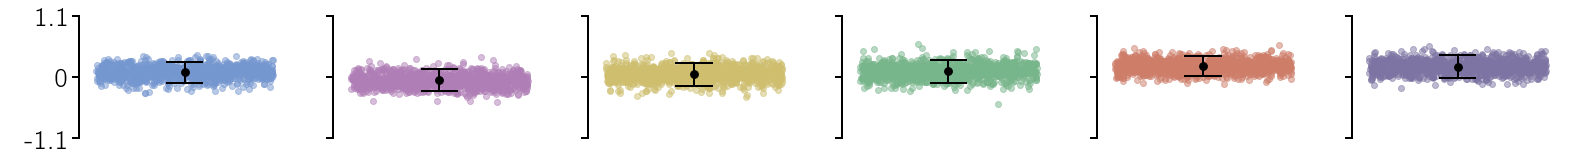

----- SNRI_EXPOSURES -----


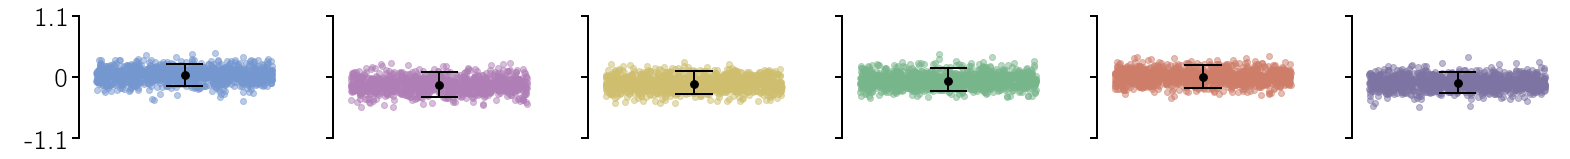

----- BENZO_EXPOSURES -----


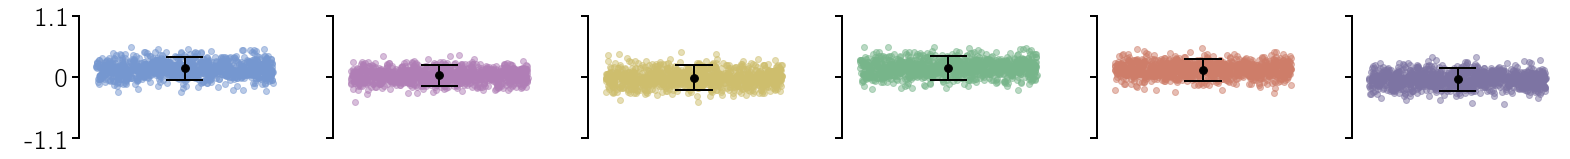

----- FGA_EXPOSURES -----


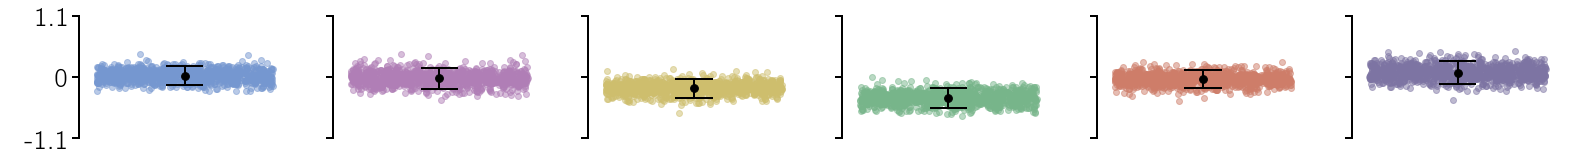

----- SGA_EXPOSURES -----


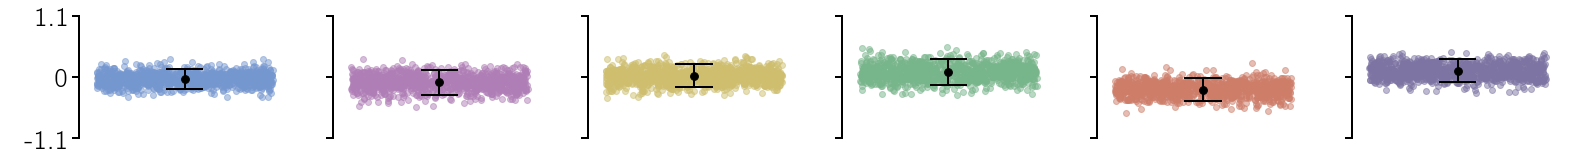

----- ER_ADMISSIONS -----


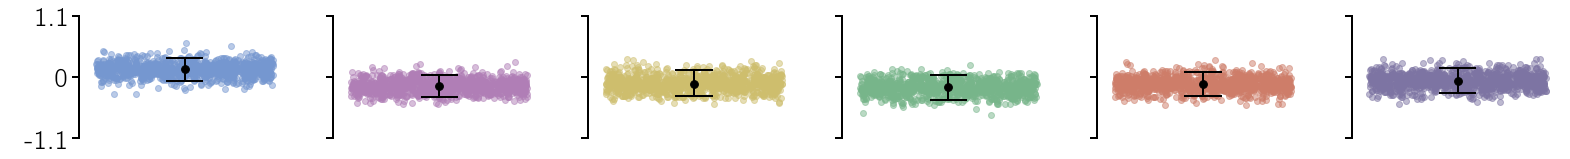

----- COST -----


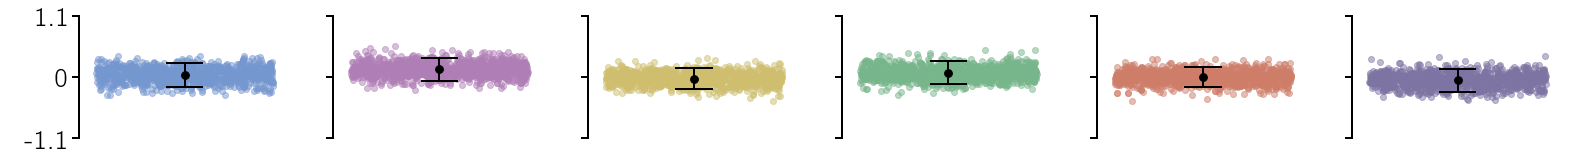

In [21]:
for i, endpoint in enumerate(endpoints.columns):
    print("----- " + endpoint.upper() + " -----")
    plot_coefs(models["data-driven"][endpoint]["coef"], 
               models["data-driven"][endpoint]["coef_boot"], 
               domains_dd, domain_names_dd, colors_dd, 
               "data-driven_{}".format(endpoint), yticks=[-1.1,0,1.1])

### RDoC

In [22]:
colors_rdoc = [c["blue"], c["red"], c["green"], c["purple"], c["yellow"], c["orange"]]
domains_rdoc = scores["rdoc"].columns
domain_names_rdoc = ["Negative\nValence", "Positive\nValence", "Cognitive\nSystems", 
                     "Social\nProcesses", "Arousal &\nRegulation", "Sensorimotor\nSystems"]

----- SSRI_EXPOSURES -----


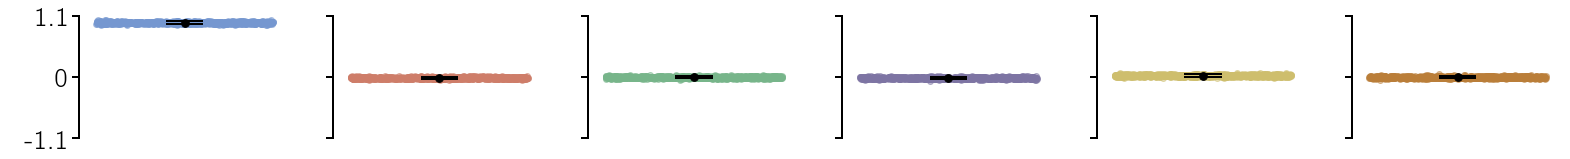

----- SNRI_EXPOSURES -----


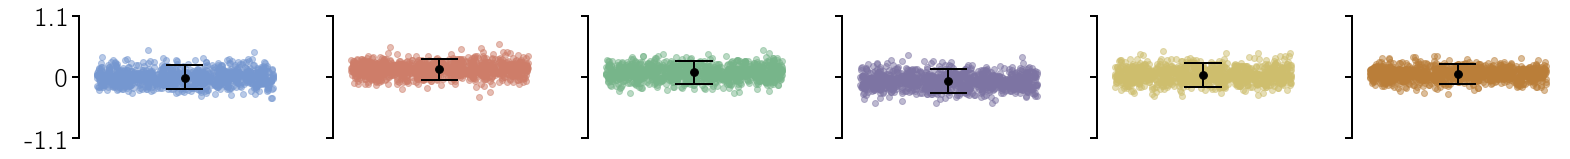

----- BENZO_EXPOSURES -----


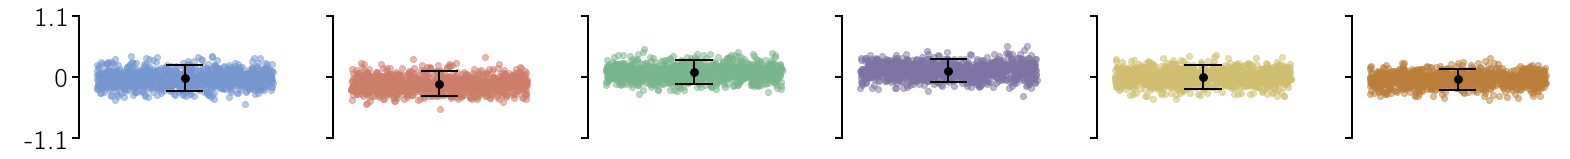

----- FGA_EXPOSURES -----


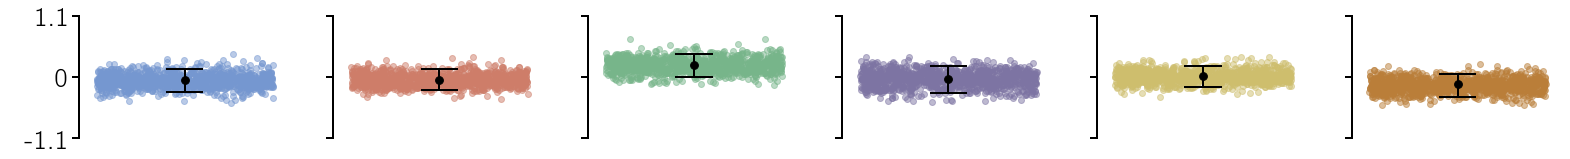

----- SGA_EXPOSURES -----


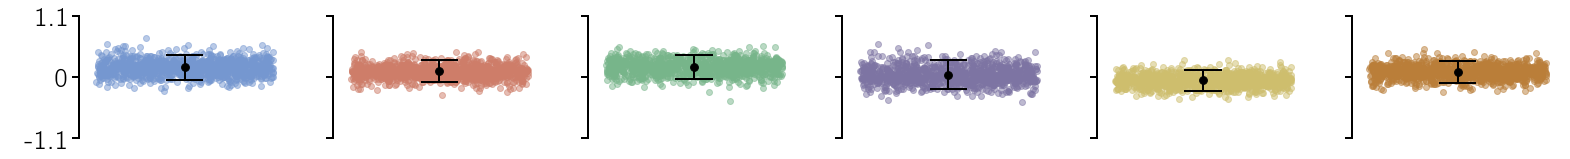

----- ER_ADMISSIONS -----


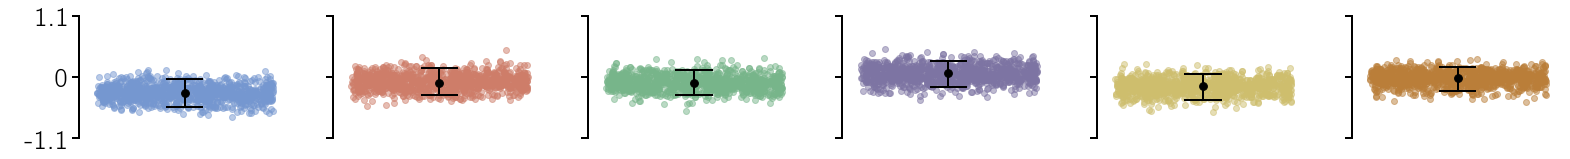

----- COST -----


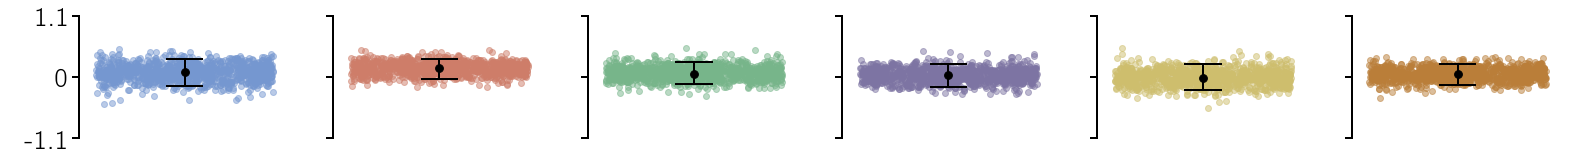

In [23]:
for i, endpoint in enumerate(endpoints.columns):
    print("----- " + endpoint.upper() + " -----")
    plot_coefs(models["rdoc"][endpoint]["coef"], 
               models["rdoc"][endpoint]["coef_boot"], 
               domains_rdoc, domain_names_rdoc, colors_rdoc, 
               "rdoc_{}".format(endpoint), yticks=[-1.1,0,1.1])

# Associate domain scores with medications

## Compute associations

In [24]:
titles = ["SSRI", "SNRI", "Benzo", "FGA", "SGA"]
var2title = {"ssri": "SSRI", "snri": "SNRI", "benzo": "Benzo", "fga": "FGA", "sga": "SGA"}

In [25]:
cors = {}
for framework in frameworks:
    
    domains = scores[framework].columns
    cors[framework] = pd.DataFrame(0.0, index=titles, columns=domains)
    
    for endpoint in endpoints.columns[:5]:
        
        med = var2title[endpoint.split("_")[0]]
        
        print("{:14s}{:24s}".format(framework, endpoint))
        print("")
        
        for domain in scores[framework].columns:
            
            r, p = scipy.stats.spearmanr(scores[framework][domain], endpoints[endpoint])
            print("\t{:20s} r={:6.6f} (p={:6.6f})".format(domain, r, p))
            if p > 0.001:
                r = 0
            cors[framework].loc[med, domain] = r
            
        print("\n")

data-driven   ssri_exposures          

	MEMORY               r=0.029202 (p=0.773033)
	REWARD               r=-0.031213 (p=0.757870)
	REACTION_TIME        r=0.012155 (p=0.904459)
	MANIPULATION         r=-0.026310 (p=0.794993)
	VISION               r=0.125866 (p=0.212104)
	HEARING              r=0.212807 (p=0.033526)


data-driven   snri_exposures          

	MEMORY               r=0.116523 (p=0.248287)
	REWARD               r=-0.049002 (p=0.628277)
	REACTION_TIME        r=-0.174178 (p=0.083069)
	MANIPULATION         r=0.024864 (p=0.806027)
	VISION               r=0.100372 (p=0.320411)
	HEARING              r=-0.090561 (p=0.370219)


data-driven   benzo_exposures         

	MEMORY               r=-0.016983 (p=0.866815)
	REWARD               r=0.013890 (p=0.890900)
	REACTION_TIME        r=0.028487 (p=0.778444)
	MANIPULATION         r=0.006738 (p=0.946950)
	VISION               r=0.049542 (p=0.624490)
	HEARING              r=0.011231 (p=0.911697)


data-driven   fga_exposures           



## Plot associations

In [26]:
from math import pi

In [27]:
c = {"red": "#CE7D69", "orange": "#BA7E39", "yellow": "#CEBE6D", 
     "chartreuse": "#AEC87C", "green": "#77B58A", "blue": "#7597D0", 
     "magenta": "#B07EB6", "purple": "#7D74A3", "brown": "#846B43", "pink": "#CF7593"}

In [28]:
linestyles = [[4, 2, 4, 2], [1, 2, 1, 2], [4, 2, 1, 2], [4, 6, 4, 6], [1, 4, 1, 4], [4, 2, 1, 2, 1, 2]]

In [29]:
font = "style/cmunbmr.ttf"
prop_sm = mpl.font_manager.FontProperties(fname=font, size=16)
prop_md = mpl.font_manager.FontProperties(fname=font, size=20)
prop_lg = mpl.font_manager.FontProperties(fname=font, size=20)
prop_xlg = mpl.font_manager.FontProperties(fname=font, size=24)
mpl.rcParams["axes.linewidth"] = 1.5
mpl.rcParams["axes.axisbelow"] = False

In [30]:
def plot_radar(framework, df, domains, colors, labels=False, 
               lgd_x=1.2, yticks=[0.05, 0.1, 0.15, 0.2, 0.25]):
    
    fig = plt.figure(figsize=(6, 6))
    df = df.transpose()
    categories = ["SSRI", "SNRI", "Benzo", "FGA", "SGA"]
    N = len(categories)

    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    ax = plt.subplot(111, polar=True)
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
    plt.xticks(angles[:-1], [""]*len(categories))
    if labels:
        plt.xticks(angles[:-1], categories, width=2)
    
    ax.set_rlabel_position(0)
    
    lines, fills = [], []
    
    for i, domain in enumerate(domains):
        
        values = df.iloc[i].values.flatten().tolist()
        values += values[:1]
        
        line, = ax.plot(angles, values, colors[i], linewidth=2.5)
        line.set_dashes(linestyles[i])
        lines.append(line)
        
        fill, = ax.fill(angles, values, colors[i], alpha=0.15)
        fills.append(fill)
    
    lgd = ax.legend(zip(lines, fills), domains, prop=prop_sm, ncol=2, 
                    bbox_to_anchor=(lgd_x, -0.05), frameon=False,
                    handlelength=3.26)
    
    plt.yticks(yticks, [" " + str(tick) for tick in yticks[:-1]] + [" "], 
               color="black", fontproperties=prop_md)
    plt.ylim(0, yticks[-1])
    
    plt.savefig("figures/meds_radar_{}.png".format(framework), 
                dpi=250, bbox_inches="tight")
    plt.show()

### Data-driven

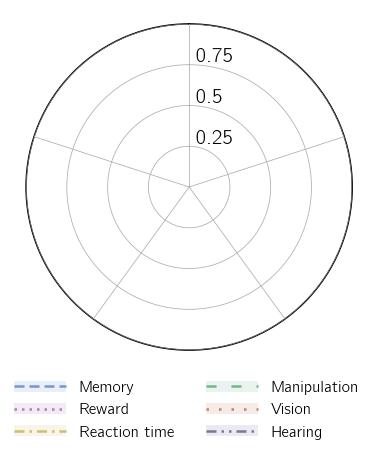

In [31]:
colors_dd = [c["blue"], c["magenta"], c["yellow"], c["green"], c["red"], c["purple"]]
domains_dd = ["Memory", "Reward", "Reaction time", "Manipulation", "Vision", "Hearing"]
plot_radar("data-driven", cors["data-driven"], domains_dd, colors_dd, labels=False, 
           lgd_x=1.065, yticks=[0.25, 0.5, 0.75, 1])

### RDoC

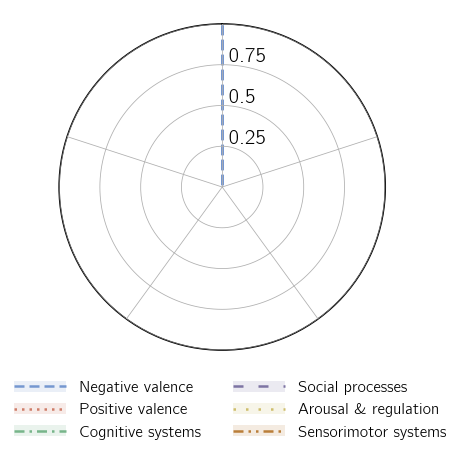

In [32]:
colors_rdoc = [c["blue"], c["red"], c["green"], c["purple"], c["yellow"], c["orange"]]
domains_rdoc = ["Negative valence", "Positive valence", "Cognitive systems",
                "Social processes", "Arousal & regulation", "Sensorimotor systems"]
plot_radar("rdoc", cors["rdoc"], domains_rdoc, colors_rdoc, labels=False, 
           lgd_x=1.23, yticks=[0.25, 0.5, 0.75, 1])